# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

In [ ]:
import os

dir_content = os.listdir()
if 'eng.testa' not in dir_content and 'eng.train' not in dir_content:
    !wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
    !wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from sklearn.metrics import classification_report
import itertools
import math

In [ ]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 668417.64it/s]


In [ ]:
len(valid['sentences'])

3250

In [ ]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [ ]:
valid["sentences"][1], valid["labels_per_sent"][1]

(['LONDON', '1996-08-30'], ['LOC', 'O'])

In [ ]:
def truncate_dataset(dataset): # ram is dying for some reason. Until better days - a hack
    truncated_sentences = []
    truncated_labels = []
    for sentence, labels in zip(dataset['sentences'], dataset['labels_per_sent']):
        if len(sentence) < 40:
            truncated_sentences.append(sentence)
            truncated_labels.append(labels)
    return truncated_sentences, truncated_labels
train['sentences'], train['labels_per_sent'] = truncate_dataset(train)
valid['sentences'], valid['labels_per_sent'] = truncate_dataset(valid)

In [ ]:
word_list = list(set(itertools.chain(*train['sentences']))) + ['PAD'] + ['OOV']
label_list = list(set(itertools.chain(*train['labels_per_sent'])))
labels_to_ids = {k:v for v, k in enumerate(label_list)}
ids_to_labels = {v:k for v, k in enumerate(label_list)}
words_to_ids = {k:v for v, k in enumerate(word_list)}
ids_to_words = {v:k for v, k in enumerate(word_list)}

In [ ]:
labels_to_ids

{'LOC': 1, 'MISC': 2, 'O': 0, 'ORG': 4, 'PER': 3}

In [ ]:
def get_label_distribution(labels: List[List[str]]):
  labels = [label for labels_per_sent in labels for label in labels_per_sent]
  return Counter(labels)

In [ ]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

Train distribution


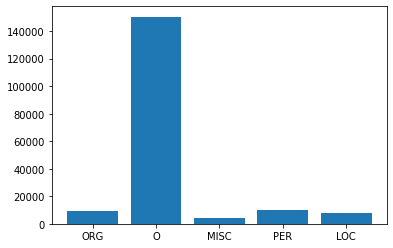

Valid distribution


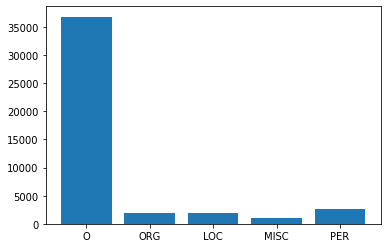

In [ ]:
def visualize_distr(data: Counter):
  labels = list(data.keys())
  plt.bar(x=labels, height=list(data.values()))
  plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_seq_len, d_model)
        pe.requires_grad = False
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

In [ ]:
def attention(q, k, v, mask = None, dropout = None):
    scores  = q.matmul(k.transpose(-2, -1))
    scores /= math.sqrt(q.shape[-1])

    scores = scores if mask is None else scores.masked_fill(mask == 0, -1e3)

    scores = F.softmax(scores, dim = -1)
    scores = dropout(scores) if dropout is not None else scores
    output = scores.matmul(v)
    return output

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, out_dim, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(out_dim, out_dim*3)
        self.n_heads = n_heads
        self.out_dim = out_dim
        self.out_dim_per_head = out_dim // n_heads
        self.out = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def split_heads(self, t):
        return t.reshape(t.shape[0], -1, self.n_heads, self.out_dim_per_head)

    def forward(self, x, y=None, mask=None):
        y = x if y is None else y 

        qkv = self.linear(x)
        q = qkv[:, :, :self.out_dim]
        k = qkv[:, :, self.out_dim:self.out_dim * 2]
        v = qkv[:, :, self.out_dim * 2:]

        q, k, v = [self.split_heads(t) for t in (q, k, v)]
        q, k, v = [t.transpose(1, 2) for t in (q, k, v)]

        scores = attention(q, k, v, mask, self.dropout)
        scores = scores.transpose(1, 2).contiguous().view(scores.shape[0], -1, self.out_dim)
        out = self.out(scores)

        return out
        

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, inp_dim, inner_dim, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(inp_dim, inner_dim)
        self.linear2 = nn.Linear(inner_dim, inp_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, inner_transformer_size, inner_ff_size, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, inner_transformer_size, dropout)
        self.ff = FeedForward(inner_transformer_size, inner_ff_size, dropout)
        self.norm1 = nn.LayerNorm(inner_transformer_size)
        self.norm2 = nn.LayerNorm(inner_transformer_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.mha(x2, mask = mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.ff(x2))
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, n_code, n_heads, embed_size, inner_ff_size, n_embeddings, seq_len, n_targets, dropout=0.1):
        super().__init__()

        self.embeddings = nn.Embedding(n_embeddings, embed_size)
        self.pe = PositionalEmbedding(embed_size, seq_len)

        encoders = []
        for i in range(n_code):
            encoders += [EncoderLayer(n_heads, embed_size, inner_ff_size, dropout)]
        self.encoders = nn.ModuleList(encoders)

        self.norm = nn.LayerNorm(embed_size)
        self.linear = nn.Linear(embed_size, n_targets, bias=False)

    def forward(self, x, mask):
        x = self.embeddings(x)
        x = x + self.pe(x)
        for encoder in self.encoders:
            x = encoder(x, mask)
        x = self.norm(x)
        x = self.linear(x)
        return x

In [ ]:
class NERDataset(Dataset):

  def __init__(self, data, seq_len=60):
    self.seq_len = seq_len
    self.encoded_sentences = []
    self.encoded_labels = []
    self.oov_id = words_to_ids['OOV']
    for sentence in data['sentences']:
      encoded_sentence = [words_to_ids[word] if word in words_to_ids.keys() else self.oov_id  for word in sentence]
      self.encoded_sentences.append(encoded_sentence)
    for sentence_labels in data['labels_per_sent']:
      enc_sent_labels = [labels_to_ids[label] for label in sentence_labels]
      self.encoded_labels.append(enc_sent_labels)
      
  def __getitem__(self, index):

    sentence = train['sentences'][index]
    padding_len = (self.seq_len - len(sentence))
    padding = ['PAD'] * padding_len
    sentence = sentence[:] + padding
    encoded_sentence = [words_to_ids[word] for word in sentence]

    labels = train['labels_per_sent'][index]
    encoded_labels = [labels_to_ids[label] for label in labels]
    label_padding = [-100] * padding_len
    encoded_labels += label_padding
    attention_mask = [1] * self.seq_len
    for i in range(padding_len):
      attention_mask[-i-1] = 0
    
    return torch.Tensor((encoded_sentence, encoded_labels, attention_mask))

  def __len__(self):
    return len(self.encoded_sentences)

In [ ]:
embed_size = 64
n_code = 4
n_heads = 8
inner_ff_size = 256
n_embeddings = len(words_to_ids.keys())
seq_len = 40
n_targets = len(label_list)

In [ ]:
train_dataset = NERDataset(train, seq_len=seq_len)
valid_dataset = NERDataset(valid, seq_len=seq_len)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = Transformer(n_code, n_heads, embed_size, inner_ff_size, n_embeddings, seq_len, n_targets)
if device.type == 'cuda':
    model = model.to(device)

In [ ]:
def transform_logits(predictions: List[torch.tensor]):
  output = F.softmax(predictions, dim=1)
  return output

def transform_target(target_labels: List[torch.tensor]):
  pass

In [ ]:
def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
  gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
  predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]
  unpadded_gold_labels = []
  unpadded_predict_labels = []
  for gold_label, pred_label  in zip(gold_labels, predict_labels):
      if gold_label != -100:
          unpadded_gold_labels.append(gold_label)
          unpadded_predict_labels.append(pred_label)

  print(classification_report(unpadded_gold_labels, unpadded_predict_labels, zero_division=1))

In [ ]:
optim_kwargs = {'lr':2e-3, 'weight_decay':1e-4, 'betas':(.9,.999)}

In [ ]:
losses = {"train_losses": [], "valid_losses": []}

epochs = 10
optimizer = Adam(model.parameters(), **optim_kwargs)

criterion = torch.nn.CrossEntropyLoss()

if device.type == 'cuda':
  criterion = criterion.to(device)

for epoch in range(epochs):

  print(f"Start epoch #{epoch}")
  model.train()
  train_stream = tqdm(train_dataloader) 
  for train_batch in train_stream:
    if device.type == 'cuda':
      train_batch = train_batch.to(device)
    words, targets, attention_mask = train_batch[0]
    output = model.forward(words.long(), attention_mask)
    output = output.permute(0,2,1)
    targets = targets.view(1, -1).long()
    loss = criterion(output, targets)
    losses["train_losses"].append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_stream.set_description(f'loss = {loss}')
    

    

  predict_labels, gold_labels = [], []
  model.eval()
  for valid_batch in tqdm(valid_dataloader):
    with torch.no_grad():
      if device.type == 'cuda':
        valid_batch = valid_batch.to(device)
      words, targets, attention_mask = valid_batch[0]
      output = model.forward(words.long(), attention_mask)
      output = output.permute(0,2,1)
      targets = targets.view(1, -1).long()
      loss = criterion(output, targets)
      losses["valid_losses"].append(loss)
      gold_labels.append(targets.view(-1).tolist())
      predict_labels.append(transform_logits(output).argmax(1).squeeze().tolist())

  count_metrics(gold_labels, predict_labels)
  
  print(f"End epoch #{epoch}")

Start epoch #0


100%|██████████| 3098/3098 [00:45<00:00, 68.45it/s]


              precision    recall  f1-score   support

           0       0.96      0.99      0.98     34561
           1       0.77      0.65      0.71      2110
           2       0.72      0.35      0.47      1083
           3       0.76      0.71      0.74      2809
           4       0.51      0.46      0.49      1644

    accuracy                           0.92     42207
   macro avg       0.75      0.63      0.68     42207
weighted avg       0.91      0.92      0.91     42207

End epoch #0
Start epoch #1


100%|██████████| 3098/3098 [01:13<00:00, 42.28it/s]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     34561
           1       0.89      0.82      0.86      2110
           2       0.87      0.69      0.77      1083
           3       0.91      0.85      0.88      2809
           4       0.88      0.47      0.61      1644

    accuracy                           0.95     42207
   macro avg       0.90      0.77      0.82     42207
weighted avg       0.95      0.95      0.95     42207

End epoch #1
Start epoch #2


100%|██████████| 3098/3098 [01:20<00:00, 38.40it/s]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34561
           1       0.95      0.84      0.89      2110
           2       0.89      0.75      0.81      1083
           3       0.93      0.91      0.92      2809
           4       0.82      0.73      0.77      1644

    accuracy                           0.96     42207
   macro avg       0.91      0.84      0.88     42207
weighted avg       0.96      0.96      0.96     42207

End epoch #2
Start epoch #3


100%|██████████| 3098/3098 [01:17<00:00, 40.07it/s]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     34561
           1       0.85      0.92      0.88      2110
           2       0.93      0.77      0.84      1083
           3       0.93      0.91      0.92      2809
           4       0.84      0.75      0.79      1644

    accuracy                           0.97     42207
   macro avg       0.91      0.87      0.89     42207
weighted avg       0.97      0.97      0.97     42207

End epoch #3
Start epoch #4


100%|██████████| 3098/3098 [01:21<00:00, 37.84it/s]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     34561
           1       0.94      0.86      0.90      2110
           2       0.91      0.81      0.86      1083
           3       0.95      0.90      0.92      2809
           4       0.77      0.81      0.79      1644

    accuracy                           0.97     42207
   macro avg       0.91      0.87      0.89     42207
weighted avg       0.97      0.97      0.97     42207

End epoch #4
Start epoch #5


 18%|█▊        | 2371/13546 [03:36<33:29,  5.56it/s]